In [1]:
#import necessary libraries
import io
import os
import PIL
import zipfile
from PIL import Image
import shutil
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

import pathlib
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# **Dataset Inspection**

In [2]:
data_dir = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

In [3]:
image_classes = [os.path.join(data_dir, image_class) for image_class in os.listdir(data_dir)]
for image_class in image_classes:
    print(f"The total number of images in {image_class.split('/')[-1]} class is {len(os.listdir(image_class))}")
# print(f"The total number of image class used is {len(image_classes)}")

The total number of images in beetle class is 60
The total number of images in parrot class is 60
The total number of images in fox class is 60
The total number of images in wolf class is 60
The total number of images in hedgehog class is 60
The total number of images in turtle class is 60
The total number of images in snake class is 60
The total number of images in shark class is 60
The total number of images in horse class is 60
The total number of images in antelope class is 60
The total number of images in hamster class is 60
The total number of images in woodpecker class is 60
The total number of images in eagle class is 60
The total number of images in chimpanzee class is 60
The total number of images in bison class is 60
The total number of images in penguin class is 60
The total number of images in butterfly class is 60
The total number of images in sandpiper class is 60
The total number of images in hornbill class is 60
The total number of images in lion class is 60
The total 

In [4]:
image_classes = [os.path.join(data_dir, image_class) for image_class in os.listdir(data_dir)]
print(f"The total number of image class used is {len(image_classes)}")

The total number of image class used is 90


In [5]:
images = [os.path.join(data_dir, image_class, image) for image_class in os.listdir(data_dir) for image in os.listdir(os.path.join(data_dir, image_class))]
print(f"The total number of images is {len(images)}")

The total number of images is 5400


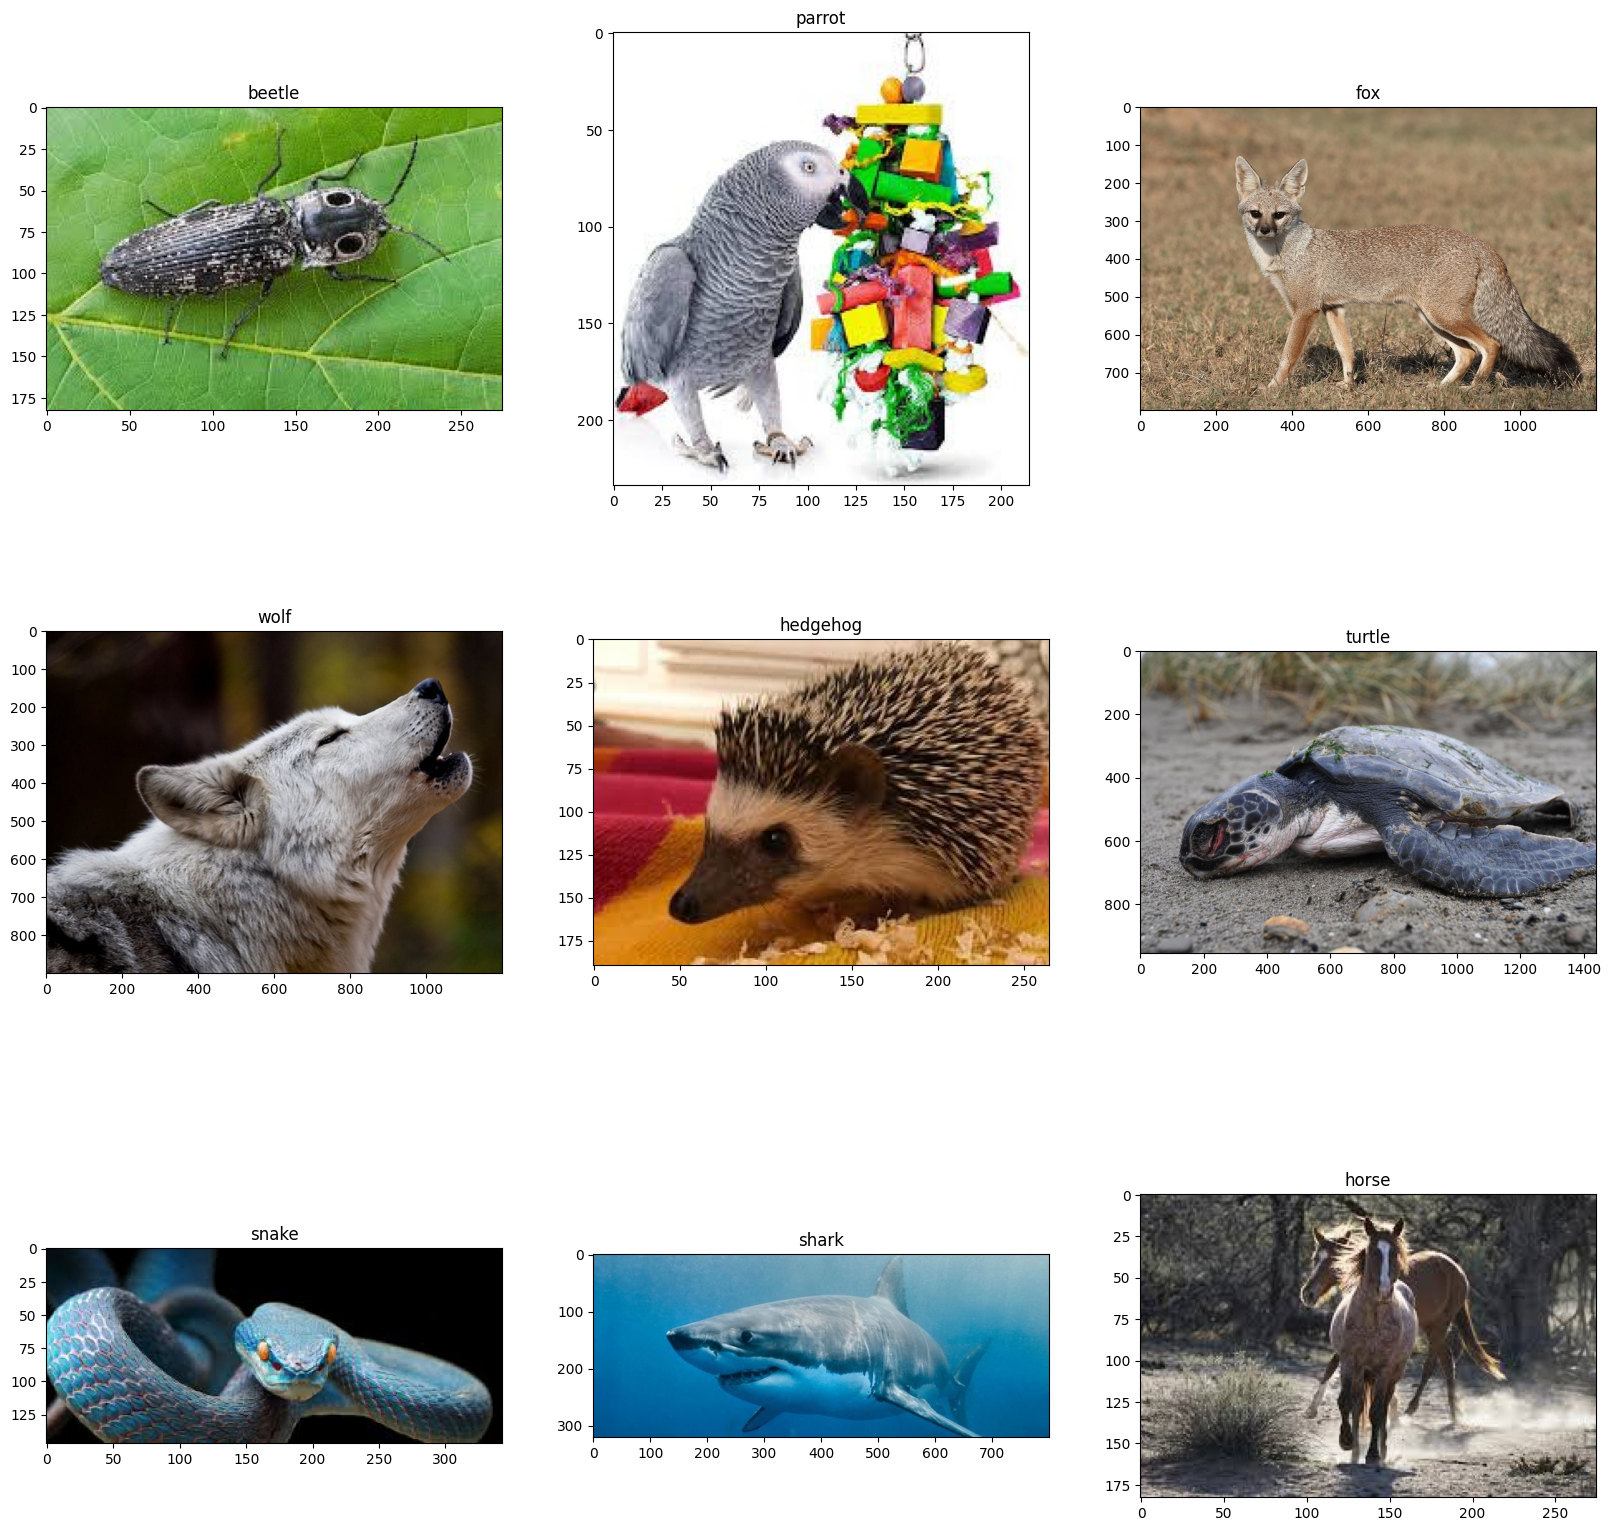

In [6]:
# let's take a look at some images
plt.figure(figsize=(20, 20))

# define the location of the dataset
image_classes = [os.path.join(data_dir, image_class) for image_class in os.listdir(data_dir)]

# limit the number of images to be displayed to 9 or the total number of folders
num_images_to_display = min(len(image_classes), 9)

# plot the first image from each class with the folder name as title
for i in range(num_images_to_display):
    class_folder = image_classes[i]
    
    # list all images in the class folder
    class_images = [os.path.join(class_folder, img) for img in os.listdir(class_folder)]
    
    # select the first image
    if class_images:
        first_image = class_images[0]
        
        # define subplot
        plt.subplot(3, 3, i + 1)
        
        # load and plot the image
        image = imread(first_image)
        plt.imshow(image)
        
        # extract and add the folder name as title
        folder_name = os.path.basename(class_folder)
        plt.title(folder_name)

# show the figure
plt.show()

# **Data Preprocessing**

In [7]:
def preprocess_data(image_folders, target_size=(128, 128)):
    """
    Preprocess image data by loading, resizing, and normalizing.

    Parameters:
    - image_folders (list): List of folders containing images.
    - target_size (tuple): Target size for resizing images.

    Returns:
    - images (numpy array): Preprocessed image data.
    - image_labels (numpy array): Corresponding labels.
    """

    images = []  # list to store preprocessed images
    image_labels = []  # list to store corresponding labels

    for i, class_folder in enumerate(image_folders):
        class_name = os.path.basename(class_folder)  # getting the folder name as the class label
        class_images = [os.path.join(class_folder, img) for img in os.listdir(class_folder)]

        for img_path in class_images:
            # load and preprocess the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
            image = cv2.resize(image, target_size)  # resize the image
            image = image / 255.0  # normalize pixel values to the range [0, 1]

            # append the preprocessed image and label to the lists
            images.append(image)
            image_labels.append(class_name)  # use the index of the class folder as the label

    # convert the lists to numpy arrays
    images = np.array(images)
    image_labels = np.array(image_labels)

    return images, image_labels

In [8]:
def split_data_and_create_directories(X, y, output_dir, test_size=0.2, validation_size=0.25, random_state=None):
    """
    Split the data into training, validation, and test sets, and create directories for each split.

    Parameters:
    - images (numpy array): Image data.
    - image_labels (numpy array): Corresponding labels.
    - output_dir (str): Directory to save the split data.
    - test_size (float): Fraction of the data to reserve for the test set.
    - validation_size (float): Fraction of the remaining data to reserve for the validation set.
    - random_state (int or None): Seed for reproducibility.

    Returns:
    - training_images, val_images, test_images, training_labels, val_labels, test_labels: Split data and labels.
    """

    # create directories for each split
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "validation")
    test_dir = os.path.join(output_dir, "test")

    for directory in [train_dir, val_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

    # split the data into training and test sets
    training_images, test_images, training_labels, test_labels = train_test_split(images, image_labels, test_size=test_size, random_state=random_state, stratify=image_labels)

    # split the remaining data into training and validation sets
    training_images, val_images, training_labels, val_labels = train_test_split(training_images, training_labels, test_size=validation_size / (1 - test_size),
                                                      random_state=random_state, stratify=training_labels)

    # save images to their respective directories
    save_images(training_images, training_labels, train_dir)
    save_images(val_images, val_labels, val_dir)
    save_images(test_images, test_labels, test_dir)

    return training_images, val_images, test_images, training_labels, val_labels, test_labels

def save_images(images, image_labels, output_dir):
    """
    Save images to their respective directories.

    Parameters:
    - images (numpy array): Image data.
    - image_labels (numpy array): Corresponding labels.
    - output_dir (str): Directory to save the images.
    """

    for image, label in zip(images, image_labels):
        class_dir = os.path.join(output_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

        image_path = os.path.join(class_dir, f"{hash(image.tobytes())}.png")
        plt.imsave(image_path, image)

In [9]:
output_dir = "/kaggle/working/"

data_dir = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
image_folders = [os.path.join(data_dir, image_class) for image_class in os.listdir(data_dir)]

images, image_labels = preprocess_data(image_folders)

# split the data and create directories
training_images, val_images, test_images, training_labels, val_labels, test_labels = split_data_and_create_directories(
    images, image_labels, output_dir, test_size=0.2, validation_size=0.25, random_state=42
)

In [10]:
def count_images_in_folders(root_dir):
    """
    Count the number of images in each class folder within the root directory.

    Parameters:
    - root_dir (str): Root directory containing class folders.

    Returns:
    - counts (dict): Number of images per class.
    """

    counts = {}

    for class_folder in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_folder)

        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.endswith('.png') or f.endswith('.jpg')])
            counts[class_folder] = image_count

    return counts


root_directory = "/kaggle/working/"

train_counts = count_images_in_folders(os.path.join(root_directory, "train"))
val_counts = count_images_in_folders(os.path.join(root_directory, "validation"))
test_counts = count_images_in_folders(os.path.join(root_directory, "test"))

print("Number of images in training set:", sum(train_counts.values()))
print("Number of images in validation set:", sum(val_counts.values()))
print("Number of images in test set:", sum(test_counts.values()))

Number of images in training set: 2970
Number of images in validation set: 1350
Number of images in test set: 1080


# **Model Training**

In [34]:
input_shape = (224, 224, 3)

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen =  ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [50]:
# define the data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# define the directory paths
train_dir = "/kaggle/working/train"
validation_dir = "/kaggle/working/validation"
test_dir = "/kaggle/working/test"

# set up the data generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=300,
    class_mode='categorical'
)

Found 2970 images belonging to 90 classes.
Found 1350 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


## **Baseline Model**

In [54]:
#baseline model
model = Sequential()

model.add(Conv2D(32, 3, input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(90, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 193600)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [55]:
# fit the model
results = model.fit(train_gen, 
                    steps_per_epoch=train_gen.samples // train_gen.batch_size,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // val_gen.batch_size)

Epoch 1/10
92/92 [==============================] - 108s 1s/step - loss: 5.0261 - accuracy: 0.0204 - val_loss: 4.3991 - val_accuracy: 0.0335
Epoch 2/10
92/92 [==============================] - 108s 1s/step - loss: 4.3308 - accuracy: 0.0293 - val_loss: 4.2722 - val_accuracy: 0.0432
Epoch 3/10
92/92 [==============================] - 109s 1s/step - loss: 4.2254 - accuracy: 0.0480 - val_loss: 4.1619 - val_accuracy: 0.0580
Epoch 4/10
92/92 [==============================] - 108s 1s/step - loss: 4.0920 - accuracy: 0.0756 - val_loss: 4.0305 - val_accuracy: 0.0833
Epoch 5/10
92/92 [==============================] - 108s 1s/step - loss: 3.9640 - accuracy: 0.0929 - val_loss: 4.0320 - val_accuracy: 0.0796
Epoch 6/10
92/92 [==============================] - 108s 1s/step - loss: 3.8450 - accuracy: 0.0970 - val_loss: 3.8437 - val_accuracy: 0.1019
Epoch 7/10
92/92 [==============================] - 107s 1s/step - loss: 3.7314 - accuracy: 0.1215 - val_loss: 3.8113 - val_accuracy: 0.1324
Epoch 8/10
92

In [56]:
# test accuracy
test_loss, test_acc = model.evaluate(test_gen)
print('Test accuracy:', test_acc)

4/4 [==============================] - 9s 2s/step - loss: 3.7133 - accuracy: 0.1426
Test accuracy: 0.14259259402751923


In [57]:
# fuction to plot loss and metrics vs number of epochs with train and validation sets
def visualize_training_results(results):
    history = results.history
    
    # create two axis objects side by side
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    
    # plot loss on the first axis
    ax1.plot(history['val_loss'])
    ax1.plot(history['loss'])
    ax1.legend(['val_loss', 'loss'], loc='upper left', fontsize=9)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

      # plot recall and f1 score metrics on the second axis
    ax2.plot(history['val_accuracy'])
    ax2.plot(history['accuracy'])
    ax2.legend(['val_accuracy', 'accuracy'], loc='upper left', fontsize=9)
    ax2.set_title('Accuracy score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Evaluation metrics')

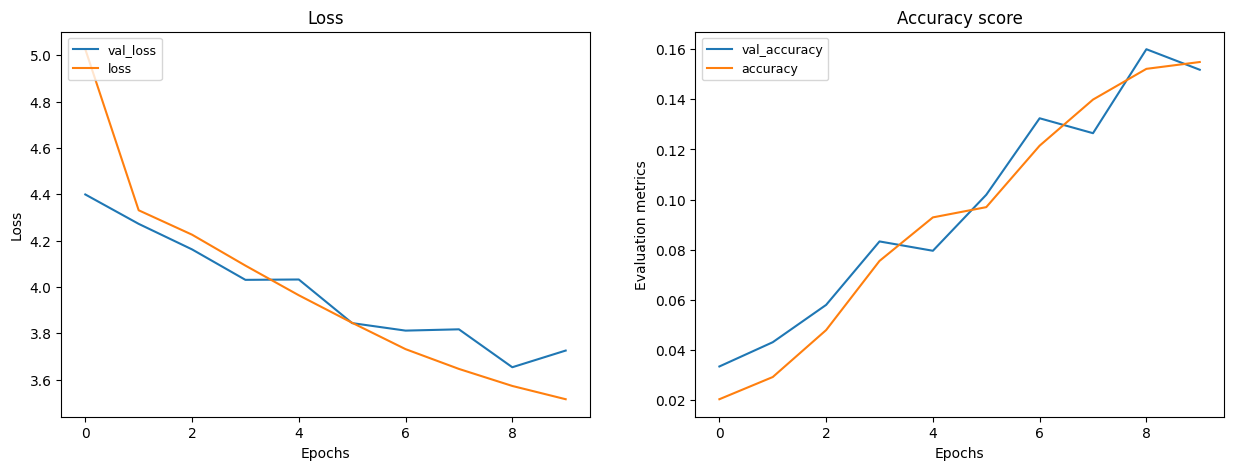

In [58]:
# visualize the results
visualize_training_results(results)

### Observations:

The training accuracy and validation accuracy exhibit a slight discrepancy.

A small difference between training and validation accuracy is indicative of reasonable model generalization. When such a modest discrepancy is observed, it suggests that the model is able to generalize well to the training data.

To further enhance the model's generalization capabilities and mitigate overfitting, the application of data augmentation is recommended.

*Data augmentation serves as a technique to augment the size and diversity of a dataset by generating synthetic data from the existing samples. This approach, widely utilized in machine learning and deep learning, aims to bolster the model's performance and robustness.*

The fundamental concept of data augmentation involves applying various transformations to the original data. These transformations include operations such as flipping, rotating, scaling, cropping, and introducing noise. By doing so, new samples are created that retain similarities with the original data while introducing variability. This strategy assists the model in learning more generalized and invariant features, thereby diminishing the risk of overfitting.

For instance, in the context of image classification, data augmentation proves effective by randomly applying operations like cropping, flipping, rotating, or adjusting the brightness and contrast of the initial images. This diversified training set helps the model to better generalize to unseen data and enhances its overall performance.

### Hyper-parameter Tunning & Model Optimization

1. Adding a dropout layer

In [60]:
# model with a dropout layer
model = Sequential()

model.add(Conv2D(16, 3, input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(90, activation='softmax'))

# Compile model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
results = model.fit(train_gen, 
           steps_per_epoch=train_gen.samples // train_gen.batch_size,
            epochs=20,
            validation_data=val_gen,
            validation_steps=val_gen.samples // val_gen.batch_size)

Epoch 1/20
92/92 [==============================] - 94s 1s/step - loss: 4.6004 - accuracy: 0.0075 - val_loss: 4.4998 - val_accuracy: 0.0112
Epoch 2/20
92/92 [==============================] - 80s 871ms/step - loss: 4.5007 - accuracy: 0.0095 - val_loss: 4.4998 - val_accuracy: 0.0112
Epoch 3/20
92/92 [==============================] - 80s 869ms/step - loss: 4.4998 - accuracy: 0.0119 - val_loss: 4.4998 - val_accuracy: 0.0112
Epoch 4/20
92/92 [==============================] - 80s 866ms/step - loss: 4.4977 - accuracy: 0.0106 - val_loss: 4.4999 - val_accuracy: 0.0112
Epoch 5/20
92/92 [==============================] - 79s 855ms/step - loss: 4.4855 - accuracy: 0.0129 - val_loss: 4.5001 - val_accuracy: 0.0112
Epoch 6/20
92/92 [==============================] - 80s 865ms/step - loss: 4.4358 - accuracy: 0.0228 - val_loss: 4.4702 - val_accuracy: 0.0134
Epoch 7/20
92/92 [==============================] - 78s 844ms/step - loss: 4.3639 - accuracy: 0.0320 - val_loss: 4.4907 - val_accuracy: 0.0223
Ep

In [61]:
# test accuracy
test_loss, test_acc = model.evaluate(test_gen)
print('Test accuracy:', test_acc)

4/4 [==============================] - 7s 1s/step - loss: 4.1170 - accuracy: 0.0944
Test accuracy: 0.09444444626569748


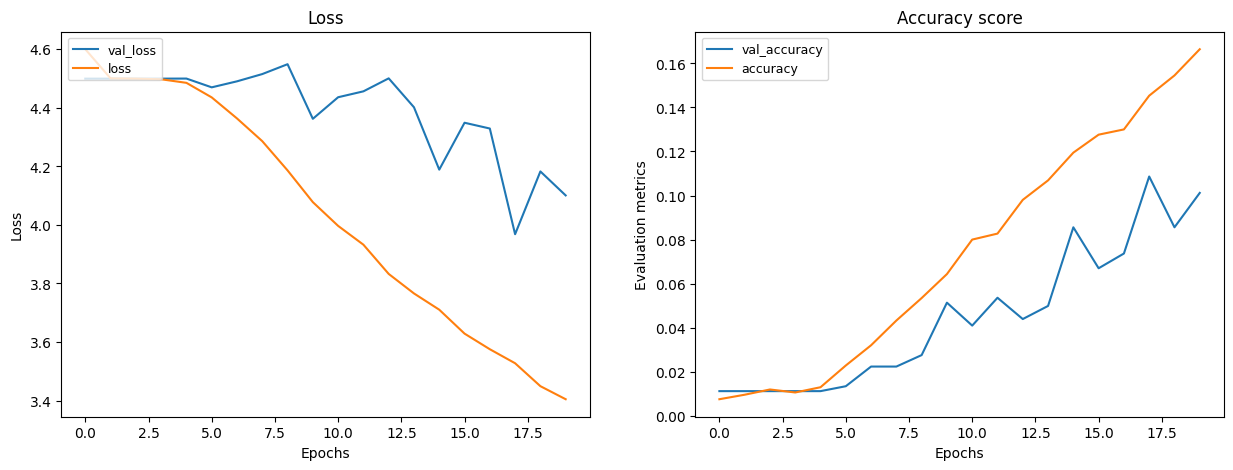

In [62]:
# visualize results
visualize_training_results(results)

### 1. InceptionV3 model
We first load the pre-trained InceptionV3 model and remove the top layer (the classification layer) by setting include_top=False. We then add a global spatial average pooling layer to the output of the base model, followed by a fully-connected layer with 512 units and ReLU activation. Finally, we add a logistic layer with 4 units and softmax activation to classify the 4 classes in our dataset.

We freeze all layers in the base model by setting their trainable attribute to False, so that only the weights of the fully-connected and logistic layers are updated during training.

In [68]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(512, activation='relu')(x)

# add a logistic layer with 4 classes
predictions = Dense(90, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
results = model.fit(train_gen,
          steps_per_epoch=train_gen.samples // train_gen.batch_size,
          epochs=10,
          validation_data=val_gen,
          validation_steps=val_gen.samples // val_gen.batch_size)

87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/10
92/92 [==============================] - 173s 2s/step - loss: 2.2225 - accuracy: 0.5129 - val_loss: 1.0760 - val_accuracy: 0.7217
Epoch 2/10
92/92 [==============================] - 198s 2s/step - loss: 0.8786 - accuracy: 0.7723 - val_loss: 0.9285 - val_accuracy: 0.7507
Epoch 3/10
92/92 [==============================] - 200s 2s/step - loss: 0.6249 - accuracy: 0.8230 - val_loss: 0.9074 - val_accuracy: 0.7649
Epoch 4/10
92/92 [==============================] - 200s 2s/step - loss: 0.5034 - accuracy: 0.8564 - val_loss: 0.8395 - val_accuracy: 0.7783
Epoch 5/10
92/92 [==============================] - 200s 2s/step - loss: 0.3987 - accuracy: 0.8836 - val_loss: 0.9010 - val_accuracy: 0.7693
Epoch 6/10
92/92 [==============================] - 199s 2s/step - loss: 0.3630 - accuracy: 0.8911 - val_loss: 0.8752 - val_accuracy: 0.7827
Epoch 7/10
92/92 [==============================] - 199s 2s/step - loss: 0.2997 - accurac

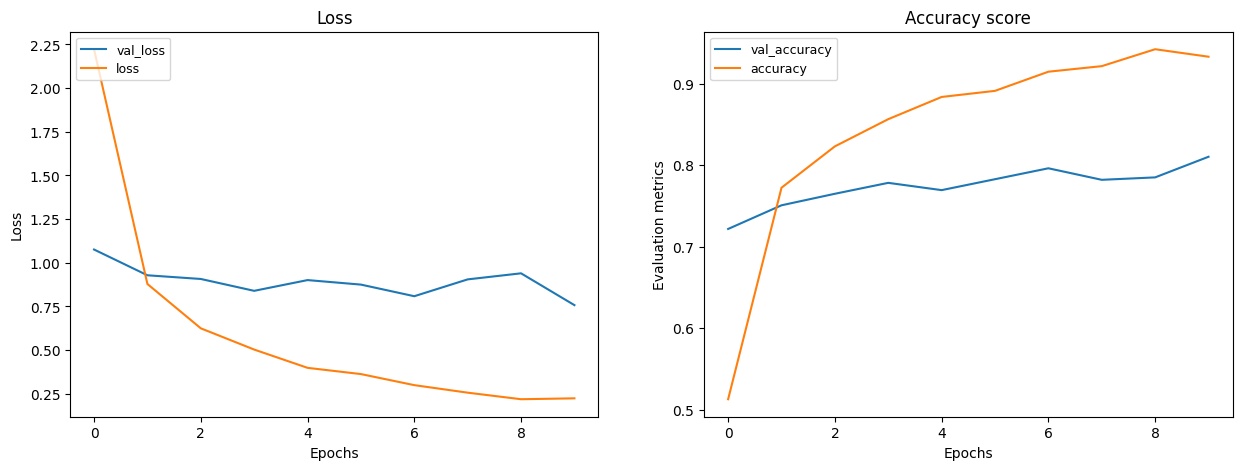

In [69]:
# visualize results
visualize_training_results(results)

In [70]:
# test accuracy
test_loss, test_acc = model.evaluate(test_gen)
print('test accuracy:', test_acc)

4/4 [==============================] - 44s 10s/step - loss: 0.6168 - accuracy: 0.8417
test accuracy: 0.8416666388511658


In [11]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/f4/79/b192c64e13eefc7f8543a10080767ab057850fa9bdbc38e7c261a3432c93/ultralytics-8.0.227-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 26.8 MB/s eta 0:00:00


3

In [12]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5310.5/8062.4 GB disk)


In [13]:
import glob
from ultralytics import YOLO
from IPython.display import Image, display

In [14]:
# custom.yaml

# Dataset
train: "/kaggle/working/train"  # path to your training image folder
val: "/kaggle/working/validation" # path to your validation image folder
nc: 90  # number of classes (adjust accordingly)

# model
nc: 90  # number of classes (same as in the dataset section)
depth_multiple: 0.33
width_multiple: 0.50

# Training
epochs: 50
batch_size: 16
imgsz: 640
cache: False
workers: 8
project: "custom"  # specify a project name
name: "yaml"  # specify a run name
exist_ok: False
pretrained: True
save: True
save_period: -1
device: 0  # GPU index (set to 0 for the first GPU, or 'cpu' for CPU)

# Other settings...
# Adjust other settings such as optimizer, learning rate, augmentation, etc.


In [15]:
import yaml

data = {
    'train': '/kaggle/working/train',  # path to your training image folder
    'val': '/kaggle/working/validation',  # path to your validation image folder
    'nc': 90  # number of classes (adjust accordingly)
}

with open('/kaggle/working/custom.yaml', 'w') as file:
    yaml.dump(data, file)

In [16]:
%cd /kaggle/working
!ls

/kaggle/working
custom.yaml  test  train  validation


In [17]:
!yolo task=detect mode=train model=yolov8n.pt data= custom.yaml epochs=10 imgsz=640

100%|███████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 108MB/s]
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=custom.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

In [18]:
!ls 'runs/detect/train'

args.yaml					  train_batch0.jpg  weights
events.out.tfevents.1702568472.51e67caab0a1.99.0  train_batch1.jpg
results.csv					  train_batch2.jpg


# Visualize the training output

In [19]:
display(Image(filename="runs/detect/train/confusion_matrix_normalized.png", width=1000))

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train/confusion_matrix_normalized.png'

In [ ]:
display(Image(filename="runs/detect/train/results.png", width=1000))

In [ ]:
display(Image(filename="runs/detect/train/PR_curve.png", width=1000))

In [ ]:
display(Image(filename="runs/detect/train/F1_curve.png", width=1000))

In [ ]:
display(Image(filename="runs/detect/train/val_batch0_pred.jpg", width=1000))

In [ ]:
!yolo task=detect mode=val model=runs/detect/train/weights/best.pt data=custom.yaml split=test

# Visualize the test output

In [ ]:
!ls 'runs/detect/val'

In [ ]:
display(Image(filename="runs/detect/val/confusion_matrix_normalized.png", width=1000))

In [ ]:
display(Image(filename="runs/detect/val/PR_curve.png", width=1000))

In [ ]:
display(Image(filename="runs/detect/val/F1_curve.png", width=1000))

In [ ]:
display(Image(filename="runs/detect/val/val_batch0_pred.jpg", width=1000))

In [ ]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.35 source=data/test save=True

In [ ]:
img_path = glob.glob(f'./runs/detect/predict/*')

for img in img_path:
  display(Image(filename=img, width=500))
  print('\n')

In [ ]:
!yolo export model=yolov8n_saved_model/yolov8n.h5 format=saved_model